<!--# Creating and training convolutional neural networks-->
# CNN(Convolutional Neural Network) 만들고 학습시키기
<!--We will now improve upon our previous example by creating some more sophisticed image classifiers and using a more challanging dataset. Specifically, we will implement convolutional neural networks (CNNs) and train them using the CIFAR10 dataset, which uses natural color images. This dataset uses  60000 small color images of size 32x32x3 (the 3 is for the RGB color channels) and 10 class labels. 50000 of these are used for training and the remaining 10000 are for the test set. There is also a CIFAR100 version that uses 100 class labels, but we will only use CIFAR10 here. -->
이제 바로 이전의 예제보다 더 나아가 보다 더 복잡한 이미지를 분류하는 분류기를 만들어봅시다. 이제 Convolutional neural network(CNN)을 색상 이미지들의 데이터셋인 CIFAR10 을 사용하여 학습시켜봅시다. 이 데이터셋은 6만개의 작은 컬러 이미지들로 이루어져 있으며(32x32x3, 3은 컬러 채널(RGB)를 의미) 10개의 클래스로 구분되어있습니다.  5만개는 학습 데이터이고 나머지 1만개는 테스트셋입니다. 100개가 아닌 100개의 클래스로 구분되어있는 CIFAR100 또한 있찌만 여기에서는 CIFAR10 만 사용하도록 하겠습니다.

| airplane | automobile | bird | cat | deer | dog | frog | horse | ship | truck |
|:--------:|:----------:|:----:|:---:|:----:|:---:|:----:|:-----:|:----:|:-----:|
| ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/automobile4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/deer4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship4.png) | ![](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck4.png) |

<!--## 1. Define the Model-->
## 1. Model 정의하기
<!--As in the previous examples, we define our model as a subclass of `Chain`. Our CNN model will have three layers of convolutions followed by two fully connected layers. Although this is still a fairly small CNN, it will still significantly outperform a fully-connected model. After completing this notebook, you are encouraged to try an experiment yourself to verify this, such as by using the `MLP` from the previous example or similar.-->
이전 모델에서는 `Chain` 클래스의 서브 클래스로써 우리의 model을 정의했었습니다. 이번에 만들 CNN model은 세 개의 convolution layer와 이들의 결과를 input으로 가지는 두 개의 fully connected layer로 구성될 것입니다. 꽤나 작은 형태의 CNN이지만 fully connected model에 비해서 성능이 매우 우월합니다. 이 notebook을 끝마쳤을 때 만든 CNN과 이전 notebook에서 만든 MLP를 직접 실험으로 비교하여 증명해볼 수도 있겠죠.
<!--Recall from the first hands-on example that we define a model as follows.-->
첫 예제에서 model을 정의하였을 때의 내용을 다시 떠올려봅시다. 우리는 아래와 같은 방법으로 model을 정의하였었죠.
<!--1. Inside the initializer of the model chain class, provide the names and corresponding layer objects as keyword arguments to parent(super) class. -->
1. chain의 서브클래스인 model의 초기화자 안에 특정 layer의 이름과 객체를 키워드 인수 형태로 부모(super) 클래스에게 넘겨주었습니다.
<!--2. Define a `__call\__` method so that we can call the chain like a function. This method is used to implement the forward computation.-->
2. `__call__` 메서드를 정의하여 chain 클래스를 마치 함수처럼 사용하였습니다. 이 메서드는 forward 계산할 때에 사용되었죠.
> 1번은 현재 chainer v2에서는 새로운 문법으로 정의할 수 있습니다. init_scope() 스코프를 사용해서 멤버 변수를 선언하듯이 작성할 수 있게 되었죠. 이전 notebook에서도 다루었지만 아래의 이전 버전 구문은 코멘트로 처리해두고 최신 버전을 기준으로 작성하겠습니다.

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L

class MyModel(chainer.Chain):
    
    def __init__(self, n_out):
        '''
        # chainer v1
        super(MyModel, self).__init__(
            conv1=L.Convolution2D(None, 32, 3, 3, 1),
            conv2=L.Convolution2D(32, 64, 3, 3, 1),
            conv3=L.Convolution2D(64, 128, 3, 3, 1),
            fc4=L.Linear(None, 1000),
            fc5=L.Linear(1000, n_out)
        )
        '''
        # chainer v2
        super(MyModel, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 32, 3, 3, 1)
            self.conv2 = L.Convolution2D(32, 64, 3, 3, 1)
            self.conv3 = L.Convolution2D(64, 128, 3, 3, 1)
            self.fc4 = L.Linear(None, 1000)
            self.fc5 = L.Linear(1000, n_out)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

<!--## 2. Train the model-->
## 2. model 학습 시키기
<!--Let's define a 'train' function that we can also use to train other models easily later on. This function takes a model object, trains the model to classify the 10 CIFAR10 classes, and finally returns the trained model. -->
나중에 다른 model들을 쉽게 학습하는 데 사용할 수 있도록 'train' 함수를 정의해놓겠습니다. 이 함수는 model 객체를 받고 CIFAR10 데이터셋을 이용하여 학습한 뒤 학습이 끝난 model을 반환합니다.

<!--We will use this `train` function to train the `MyModel` network defined above.-->
이 `train` 함수를 사용하여 위에서 정의한 `MyModel`을 학습시켜봅시다.

In [2]:
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

def train(model_object, batchsize=64, gpu_id=0, max_epoch=20):

    # 1. Dataset
    train, test = cifar.get_cifar10()

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10_result'.format(model_object.__class__.__name__))

    # 7. Evaluator
    
    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            model.train = False
            ret = super(TestModeEvaluator, self).evaluate()
            model.train = True
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer
    
    return model
    
model = train(MyModel(10))

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.54472     0.439538       1.31171               0.524184                  4.99913       
2           1.23205     0.554798       1.22452               0.557922                  9.12268       
3           1.08029     0.612976       1.12161               0.594745                  13.4607       
4           0.954917    0.660271       1.06454               0.620422                  18.0008       
5           0.841082    0.699968       1.07782               0.618531                  22.4615       
6           0.736917    0.736916       1.06581               0.630374                  26.7266       
7           0.62265     0.778509       1.11109               0.63545                   30.9682       
8           0.522986    0.814961       1.16063               0.636146                  35.444        
9           0.421351    0.850683       1.29413               0.636146               

<!--The training has completed. Let's take a look at the results.-->
학습이 끝났습니다. 결과를 보도록 합시다.

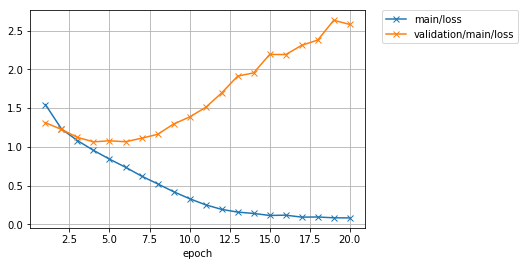

In [3]:
from IPython.display import Image
Image(filename='MyModel_cifar10_result/loss.png')

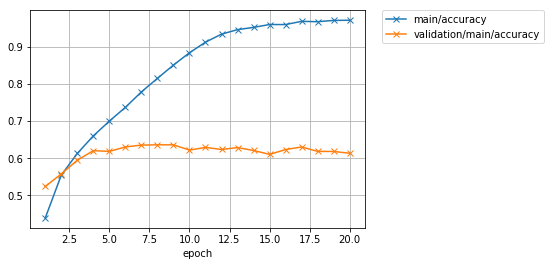

In [4]:
Image(filename='MyModel_cifar10_result/accuracy.png')

<!--Although the accuracy on the training set reach 98%, the loss on the test set started increasing after 5 epochs and the test accuracy plateaued round 60%. It looks like **the model is overfitting to the training data**. -->
학습 데이터셋의 정확도가 98%에 도달했음에도 불구하고 테스트셋의 loss는 5 epoch 까지는 증가했지만 이후 60% 언저리에서 크게 변하지 않았습니다. 

보아하니 **model이 학습 데이터에 과적합(overfitting) 된 것 같군요**

<!--## 3. Prediction using our trained model -->
## 3. 학습된 우리의 model 로 예측해보기
<!--Although the test accuracy is only around 60%, let's try classify some test images with this model.-->
테스트 정확도가 60% 정도밖에 되지 않지만 한번 이 model을 사용하여 몇몇 테스트 이미지를 분류해 봅시다.

predicted_label: cat
answer: cat


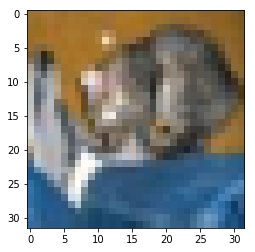

predicted_label: ship
answer: ship


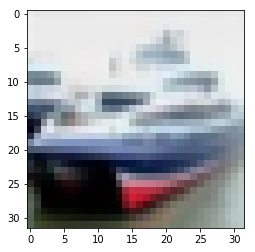

predicted_label: airplane
answer: ship


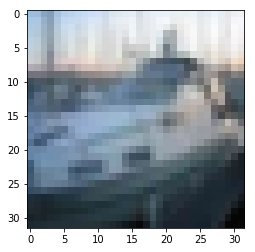

predicted_label: airplane
answer: airplane


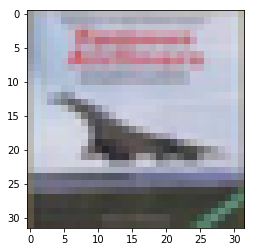

predicted_label: frog
answer: frog


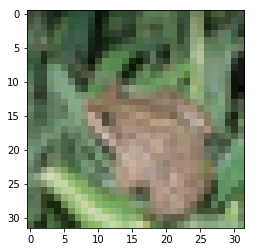

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

cls_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

def predict(model, image_id):
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    model.to_cpu()
    y = model.predictor(x[None, ...]).data.argmax(axis=1)[0]
    print('predicted_label:', cls_names[y])
    print('answer:', cls_names[t])

    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

for i in range(5):
    predict(model, i)

<!--Some are correctly classified, others are not. Even though the model can predict the classification using the training datase with 100% accuracy, it is meaningless if we cannot generalize to (previously unseen) test data. The accuracy of on the test set data is believed to estimate **generalization ability** more directly. -->
몇몇 이미지들은 올바르게 분류되었지만 나머지들은 그렇지 못하네요. 설령 model이 학습 데이터셋에 대해 100%의 정확도를 가지는 예측 분류를 수행할 수 있어도 테스트 데이터를 통해 일반화(previously unseen?)하지 못한다면 아무런 의미도 없을 것입니다. 
테스트셋 데이터의 정확도를 통해 해당 model의 일반화 능력을 직접적으로 예측할 수 있습니다.

<!--How can we design and train a model with better generalization ability?-->
그렇다면 더 나은 일반화 능력을 가지기 위해 어떻게 model을 구성하고 학습시켜야할까요?

<!--## 4. Create a deeper model-->
## 4. 더 깊은 model 만들기
<!--Let's try making our CNN deeper by adding more layers and see how it performs. We will also make our model modular by writing it as the combination of three chains. This will help to improve readability and reduce code duplication: -->
layer를 더 추가해서 우리의 CNN을 더 깊게 만든 뒤 어떤 결과를 나타내는지 봅시다. 또한 여기서 model을 모듈화 하여 3개의 chain 조합으로 나타내 보겠습니다. 이렇게 작성된 model은 가독성을 높여주고 코드 또한 줄일 수 있겠죠.
<!--- A single convolutional neural net, `ConvBlock`-->
- 하나의 convolutional neural network : `ConvBlock`
<!--- A single fully connected neural net, `LinearBlock`-->
- 하나의 fully connected neural network : `LinearBlock`
<!--- A a chain the stackes the previous two blocks to create the full model, `DeepCNN`-->
- 이전의 두 block을 엮어 전체 model을 만든 것 : `DeepCNN`

<!--### Define the block of layers-->
### layer block 정의하기
<!--Let's define the network blocks,  `ConvBlock` and `LinearBlock`, which will be stacked to create the full model.-->
network block을 정의해봅시다. `ConvBlock` 과 `LinearBlock` 두 block을 적층하여 전체 model을 구성할 것입니다.

In [6]:
class ConvBlock(chainer.Chain):
    
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal() #scaled gaussian distribution 으로 초기화
        '''
        # Chainer v1
        super(ConvBlock, self).__init__(
            conv=L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w),
            bn=L.BatchNormalization(n_ch)
        )
        self.train = True
        self.pool_drop = pool_drop
        '''
        # Chainer v2
        super(ConvBlock, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(None, n_ch, 3, 1, 1,
                                       nobias=True, initialW=w)
            self.bn = L.BatchNormalization(n_ch)
            #self.train = True
            self.pool_drop = pool_drop
        
    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25) # Chainer v2 :dropout 함수에 Train 인수를 주지 않고 학습 시 로컬 설정으로 줄 수 있음
        return h
    
class LinearBlock(chainer.Chain):
    
    def __init__(self):
        w = chainer.initializers.HeNormal()
        '''
        # Chainer v1
        super(LinearBlock, self).__init__(
            fc=L.Linear(None, 1024, initialW=w))
        self.train = True
        '''
        # Chainer v2
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc=L.Linear(None, 1024, initialW=w)
            #self.train = True
        
    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5) # Train 인수 사라짐(위의 주석 참고)

<!--`ConvBlock` is defined by inheriting `Chain`. It contains a single convolution layer and a Batch Normalization layer registered by the constructor. The `__call__` method recieves the data and applies activation funtion to it. If `pool_drop` is set to `True`, the `Max_Pooling` and `Dropout` functions are also applied. -->
`ConvBlock` 는 `Chain`을 상속받는 형태로 정의되었습니다. `ConvBlock`은 하나의 convolution layer와 Batch Normalization layer를 생성자에 포함하고 있습니다. `__call__` 메서드는 데이터를 받아 활성함수에 넣어주는 역할을 수행합니다. 만약 `pool_drop`을 `True`로 설정할 경우 `Max_Pooling` 과 `Dropout` 함수 또한 적용될 것입니다.

<!--Let's now define the deeper CNN network by stacking the component blocks.-->
이제 깊은 CNN network를 위의 block을 적층하는 방식으로 정의해봅시다.

In [7]:
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        self._train = True
            
    @property
    def train(self):
        return self._train
            
    @train.setter
    def train(self, val):
        self._train = val
        for c in self.children():
            c.train = val
    
    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x

<!--Note that `DeepCNN` inhertis from `ChainList` instead of `Chain`. The `ChainList` class inherits from `Chain` and is very useful when you define networks that consist of a long sequence of `Link` and/or `Chain` layers.-->
`DeepCNN` 이 `Chain` 이 아닌 `ChainList` 를 상속받는 것을 참고하세요. `ChainList` 클래스는 `Chain` 클래스를 상속받는 클래스이며 긴 순서의 `Link` 나 `Chain` layer로 network를 정의할 때 유용합니다.
<!--Note also the difference in the way that links and/or chains are supplied to the initializer of `ChainList`; they are passed **as normal arguments, not as keyword arguments**. Also, in the `__call__` method, they are retreived from the list in the order they were registered by calling the **self.children()** method. -->
그리고 `ChainList` 의 초기화자에서 기존의 link 혹은 chain을 적어주던 방식과 조금 다르다는 것을 참고하세요. 그들은 **이전의 키워드 인수처럼 넣는 것이 아닌 마치 일반적인 인수를 적어주듯이 넣어줍니다**. 또한 `__call__` 메서드에서 **self.children()** 메서드를 사용하여 리스트 형태로 사용하고 있다는 것도 참고하세요.

<!--This feature enables us to describe the forward propagation very concisely. With the component list returned by **self.children()**, we can write the entire forward network by using a for loop to access each component chain one after another. Then we can first set the input 'x' to the first net and its output is passed to the next series of 'Link' or 'Chain'. -->
이런 식으로 작성할 경우 forward 계산과정을 적어주는 것이 굉장히 명료해집니다. 또한 **self.children()** 메서드를 통해 반환받은 컴포넌트 리스트를 통해 forward 계산을 단순히 for 반복문을 이용하여 현재 컴포넌트와 다음 컴포넌트에 접근할 수 있게됩니다. 이를 통해 첫번째 입력 'x'를 첫째 'Link' 혹은 'Function', 'Chain' 에 넣어주고 이후 나온 결과값을 다시 다음 'Link' 혹은 'Chain'에 넣어줌으로써 간료하게 각 순서의 'Link' 혹은 'Chain' 들을 순서대로 이어줄 수 있습니다.

In [8]:
model = train(DeepCNN(10), max_epoch=100)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           2.01745     0.254496       1.54261               0.396895                  21.8864       
2           1.47597     0.441981       1.29945               0.534733                  41.5185       
3           1.19611     0.571383       1.06063               0.655354                  61.2174       
4           0.973641    0.665913       0.899149              0.705912                  81.0081       
5           0.814732    0.725464       0.741951              0.762042                  100.848       
6           0.695193    0.769366       0.681884              0.772791                  120.579       
7           0.607465    0.799576       0.564716              0.812002                  140.381       
8           0.53251     0.824724       0.545929              0.820959                  160.134       
9           0.472743    0.844909       0.511241              0.834196               

79          0.0430127   0.987356       0.662307              0.882763                  1568.2        
80          0.0447198   0.987476       0.663537              0.888336                  1588.2        
81          0.0409444   0.988231       0.79886               0.885748                  1608.13       
82          0.0388859   0.988816       0.666611              0.891919                  1627.94       
83          0.0447117   0.987456       0.699812              0.88127                   1647.8        
84          0.0436562   0.988136       0.657425              0.883459                  1667.74       
85          0.0419144   0.988011       0.672014              0.884057                  1687.44       
86          0.035944    0.990317       0.749139              0.892118                  1707.19       
87          0.0371512   0.989457       0.643754              0.888037                  1726.99       
88          0.0420933   0.988916       0.667077              0.88535              

<!--The training is completed. Let's take a look at the loss and accuracy.-->
학습이 끝났습니다. 이제 loss와 정확도를 봅시다.

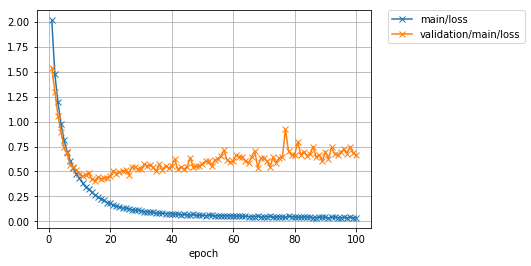

In [9]:
Image(filename='DeepCNN_cifar10_result/loss.png')

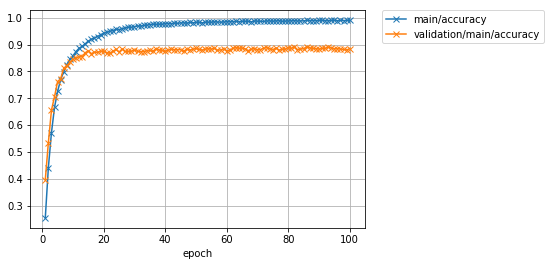

In [10]:
Image(filename='DeepCNN_cifar10_result/accuracy.png')

<!--Now the accuracy on the test set has improved a lot compared to the previous smaller CNN. Previously the accuracy was around 60% and now it is around 87%. According to current research reports, the most advanced model can reach around 97%. To improve the accuracy more, it is necessary not only to improve the models but also to increase the training data (Data augmentation) or to combine multiple models to carry out the best perfomance (Ensemble method).-->
테스트셋에서의 정확도가 이전의 작은 CNN의 비해 굉장히 많이 개선되었다는 것을 볼 수 있습니다. 이전 CNN의 정확도는 60% 정도였으나 이제는 87% 정도이군요. 최근 연구 결과에 따르면 가장 뛰어난 model은 97%의 정확도를 기록하고 있다고 합니다. 정확도를 더 높이려면 model를 개선해야하고 학습 데이터의 수를 늘리거나 다수의 model를 합쳐서*(앙상블(Ensemble)이라고도 부름)* 더 좋은 성능을 유도할 수 있을겁니다.
<!--You may also find it interesting to experiment with some larger and more difficulat datasets. There is more room for improvement by your new ideas!-->
이제 이러한 예제보다 보다 크고 까다로운 데이터셋을 기준으로 실험을 해볼 수도 있겠죠. 문은 열려있으니 당신의 아이디어를 통해 개선해봅시다!